In [1]:
# Copyright (c) 2022 Massachusetts Institute of Technology
# SPDX-License-Identifier: MIT

# Adversarial Perturbations and Concept Probing
This notebook demonstrates:
- Using the `AdditivePerturbation`, `L2ProjectedOptim`, and `solve_perturbation` functions from the `rAI-toolbox` to generate $\ell_2$-norm constrained adversarial perturbations using projected gradient descent
- How the same `AdversarialPerturbation` and `solve_perturbation` functions can be repurposed with a different optimizer (`L1qFrankWolfe`) to run an Explainable AI (XAI) task, called [Concept Probing](https://diglib.eg.org/handle/10.2312/mlvis20211072)

The dataset used in this example is the [ImageNet](https://www.image-net.org/), and the models are pretrained from Madrylab's [robustness library](https://github.com/MadryLab/robustness).

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn

from functools import partial
from pathlib import Path

from torchvision import transforms
from torch.utils.data import DataLoader

from rai_toolbox import datasets
from rai_toolbox.mushin import load_from_checkpoint, solve_perturbation
from rai_toolbox.optim import L1qFrankWolfe, L2ProjectedOptim
from rai_toolbox.perturbations import AdditivePerturbation

from rai_experiments.models import resnet
from rai_experiments.utils.imagenet_labels import IMAGENET_LABELS

# Load Data

Load the ImageNet validation dataset, and plot a few samples

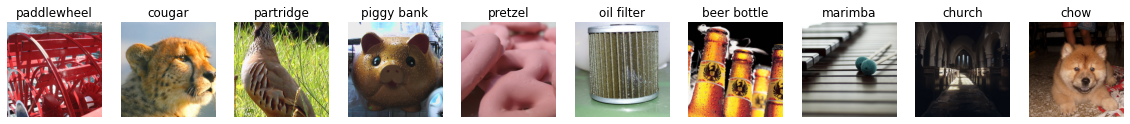

In [4]:
random_seed = 145
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
    
# Set up dataset transforms
normalizer = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
test_transforms = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor()]
)

# Load dataset
DATA_DIR = str(Path.home() / ".torch" / "data" / "imagenet" / "val")
ImageNetData = datasets.ImageNet(
    root=DATA_DIR,
    transform=test_transforms
)

# Set up dataloader
BATCH_SIZE = 10
dataloader = DataLoader(
    ImageNetData,
    batch_size = BATCH_SIZE,
    shuffle = True
)

# Sample first batch of test data and plot
x, y = next(iter(dataloader))
fig, ax = plt.subplots(1,10,figsize=(20,5))
for i in range(10):
    ax[i].imshow(x[i].permute(1,2,0))
    ax[i].set_title(IMAGENET_LABELS[y[i].item()].partition(",")[0])
    ax[i].axis("off")

# Load Pretrained Models
The pretrained models used in this example are simplified data structures of the pre-trained models available via Madrylab's robustness library [README](https://github.com/MadryLab/robustness/blob/master/README.rst), and include:
- `mitll_imagenet_l2_3_0.pt`: ResNet-50 model trained with perturbations generated via PGD using the $\ell_2$-norm with $\epsilon=3.0$
- `imagenet_nat.pt`: ResNet-50 model trained using standard training, i.e., $\epsilon=0$

In [5]:
# Load models (standard and robust)

checkpoint_robust = "mitll_imagenet_l2_3_0.pt"
checkpoint_standard = "imagenet_nat.pt"

resnet_model_robust = load_from_checkpoint(
    model=resnet.resnet50(num_classes=1000),
    ckpt=checkpoint_robust,
    weights_key="state_dict",
)

resnet_model_standard = load_from_checkpoint(
    model=resnet.resnet50(num_classes=1000),
    ckpt=checkpoint_standard,
    weights_key="model",
)

model_robust = nn.Sequential(normalizer, resnet_model_robust)
model_robust.eval();

model_standard = nn.Sequential(normalizer, resnet_model_standard)
model_standard.eval();

# Adversarial Perturbations
We will now show how to use the `solve_perturbation` function with the `AdditivePerturbation` perturbation model and `L2ProjectedOptim` optimizer from `rAI-toolbox` to solve for $\ell_2$-norm constrained adversarial perturbations using Projected Gradient Descent (PGD).

Adversarial perturbations are computed by solving the following objective:

$$\max_{||\delta||_p<\epsilon} \mathcal{L}\left(f_\theta(x+\delta), y\right) $$

where $\delta$ is the perturbation, $x$ and $y$ are the data inputs and labels, respectively, $f_\theta$ is the model parameterized by $\theta$, $\mathcal{L}$ is the loss function (e.g., cross-entropy), $||\delta||_p$ is the $\ell_p$-norm of the perturbation (for this example we'll be using $p=2$), and $\epsilon$ is the maximum allowable size of the perturbation.

In [6]:
# Parameters for perturbation optimization
EPS = 0.25
STEPS = 10
FACTOR = 2.5

# Pre-configure options for `solve_perturbation`, to be
# used across both the standard and robust model
solver_L2PGD = partial(
    solve_perturbation,
    perturbation_model = AdditivePerturbation(x.shape),
    optimizer = L2ProjectedOptim,
    # optimizer options
    lr = FACTOR*EPS/STEPS, 
    epsilon = EPS,
    # solver options
    steps = STEPS,
    targeted = False, #perturb AWAY from given target
    use_best = True,
)

In [7]:
# Generate perturbed examples
x_adv_standard, _ = solver_L2PGD(
    model = model_standard,
    data = x,
    target = y,   
)
x_adv_robust, _ = solver_L2PGD(
    model = model_robust,
    data = x,
    target = y,
)

In [8]:
# Get labels of adversarial examples
def get_predicted_label(model, x):
    logits = model(x)
    return torch.argmax(logits, axis=1)

y_standard = get_predicted_label(model_standard, x_adv_standard.clamp_(0,1))
y_robust = get_predicted_label(model_robust, x_adv_robust.clamp_(0,1))

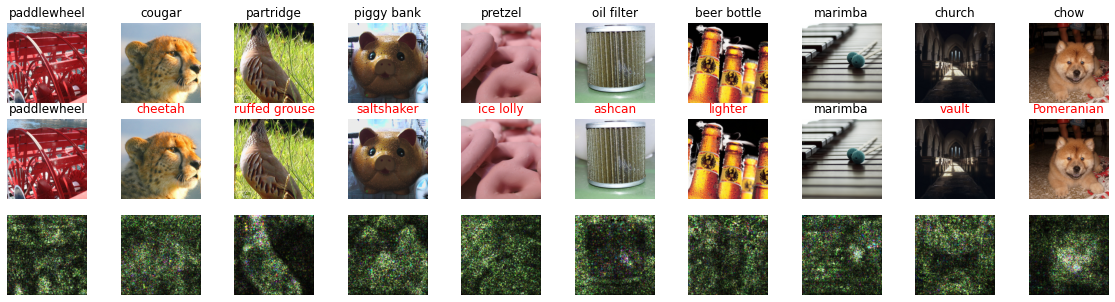

In [9]:
# Plot results for Standard Model

# First row: original images and true labels
# Second row: adversarial examples with predicted labels
# Third row: perturbations (multiplied by 100 to improve visability)
fig, ax = plt.subplots(3,10,figsize=(20,5))
for i in range(10):
    ax[0,i].imshow(x[i].permute(1,2,0))
    ax[0,i].set_title(IMAGENET_LABELS[y[i].item()].partition(",")[0])
    ax[0,i].axis("off")
    
    ax[1,i].imshow(x_adv_standard[i].clamp_(0,1).permute(1,2,0))
    if y_standard[i].item()!=y[i].item():
        ax[1,i].set_title(IMAGENET_LABELS[y_standard[i].item()].partition(",")[0],color='r')
    else:
        ax[1,i].set_title(IMAGENET_LABELS[y_standard[i].item()].partition(",")[0],color='k')
    ax[1,i].axis("off")
    ax[2,i].imshow((torch.abs(x[i]-x_adv_standard[i])*500).clamp_(0,1).permute(1,2,0))
    ax[2,i].axis("off")

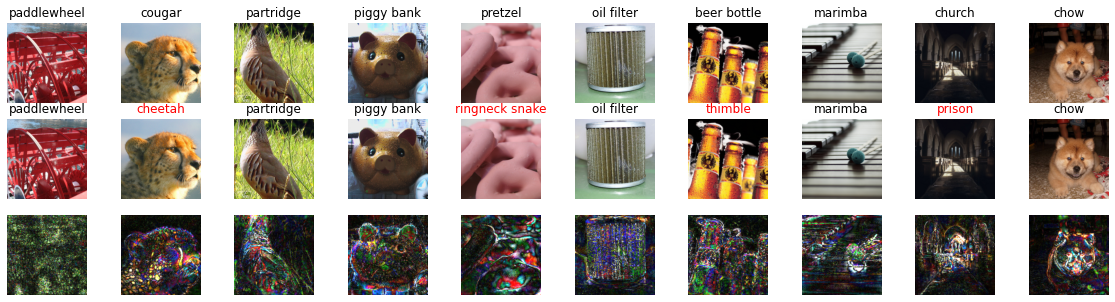

In [10]:
# Plot results for Robust Model

# First row: original images and true labels
# Second row: adversarial examples with predicted labels
# Third row: perturbations (multiplied by 100 to improve visability)
fig, ax = plt.subplots(3,10,figsize=(20,5))
for i in range(10):
    ax[0,i].imshow(x[i].permute(1,2,0))
    ax[0,i].set_title(IMAGENET_LABELS[y[i].item()].partition(",")[0])
    ax[0,i].axis("off")
    ax[1,i].imshow(x_adv_robust[i].clamp_(0,1).permute(1,2,0))
    if y_robust[i].item()!=y[i].item():
        ax[1,i].set_title(IMAGENET_LABELS[y_robust[i].item()].partition(",")[0],color='r')
    else:
        ax[1,i].set_title(IMAGENET_LABELS[y_robust[i].item()].partition(",")[0],color='k')
    ax[1,i].axis("off")
    ax[2,i].imshow((torch.abs(x[i]-x_adv_robust[i])*500).clamp_(0,1).permute(1,2,0))
    ax[2,i].axis("off")

Note that the robust model is making fewer mistakes on the adversarially-perturbed images, and the perturbations for the robust model contain a lot more structure and are more concentrated around the primary objects in the images

# Concept Probing

We will now demonstrate how the optimizer can be switched out to complete a different task, called Concept Probing. Now instead of starting with a real image from the validation set and optimizing its perturbation away from its true class, in this example, we'll be starting with a random image and optimizing its perturbation towards a class of interest, in an attempt to visualize what the model has learned for that class.

Following the approach proposed by the authors of [this paper](https://diglib.eg.org/bitstream/handle/10.2312/mlvis20211072/001-005.pdf?sequence=1&isAllowed=y), we utilize the $\ell_{1-q}$ Frank-Wolfe optimizer to solve for sparse perturbations that are more interpretable by humans.

The Frank-Wolfe optimizer solves Equation 1 above by taking convex combinations of a sequence of solutions to the linear approximation of the original problem. The $\ell_{1-q}$ constraint allows for the pixels with gradient values in the top-q percentile to be updated at each iteration.

In [11]:
# Define random image to start with
init_noise = torch.randn([1, 3, 224, 224])
init_noise = init_noise - init_noise.min()
init_noise = init_noise / init_noise.max()

In [12]:
# Define solver for concept probing example:
solver_L1FW = partial(
    solve_perturbation,
    perturbation_model=AdditivePerturbation(init_noise.shape),
    optimizer=L1qFrankWolfe,
    # optimizer options
    lr=1.0,
    epsilon=7760,
    q=0.975,
    pert_q=0.05,
    # solver options
    steps=45,
    targeted=True,
    use_best=False
)

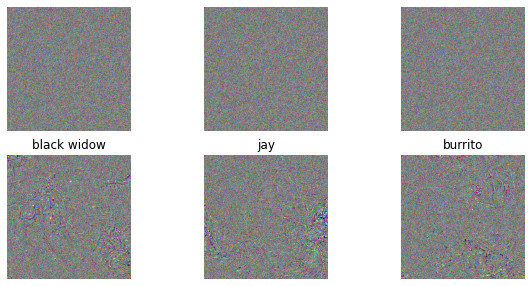

In [13]:
# Run for standard model and plot results 

# First row: original input (noise)
# Second row: optimized concepts

# Generate conecpts for 3 different arbitrary classes
target_classes = [75, 17, 965] # same classes as in Figure 3 from https://arxiv.org/abs/2201.05647

fig, ax = plt.subplots(2,3,figsize=(10,5))
for i in range(3):
    tgt = target_classes[i]
    
    # optimize loss towards target class
    target = torch.tensor([tgt])
    
    # run solver
    x_adv, _ = solver_L1FW(
        model = model_standard,
        data = init_noise,
        target = target,
    )
    
    # plot
    ax[0, i].imshow(init_noise[0].permute(1,2,0))
    ax[0, i].axis("off")
    ax[1, i].set_title(IMAGENET_LABELS[tgt].partition(",")[0])
    ax[1, i].imshow(x_adv[0].clamp_(0,1).permute(1,2,0))
    ax[1, i].axis("off")

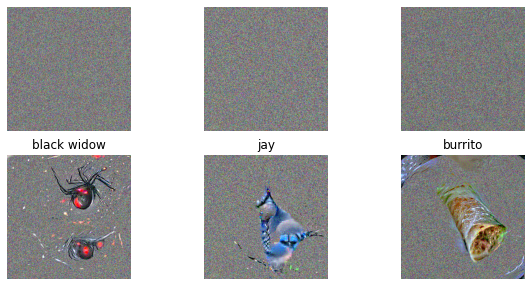

In [14]:
# Run for robust model and plot results 

# First row: original input (noise)
# Second row: optimized concepts

# Generate conecpts for 3 different arbitrary classes
target_classes = [75, 17, 965] #same classes as in Figure 3 from the paper

fig, ax = plt.subplots(2,3,figsize=(10,5))
for i in range(3):
    tgt = target_classes[i]
    
    #start with noise
    init_noise = torch.randn([1, 3, 224, 224])
    init_noise = init_noise - init_noise.min()
    init_noise = init_noise / init_noise.max()
    
    # optimize loss towards target class
    target = torch.tensor([tgt])
    
    x_adv, _ = solver_L1FW(
        model = model_robust,
        data = init_noise,
        target = target
    )
    
    ax[0, i].imshow(init_noise[0].permute(1,2,0))
    ax[0, i].axis("off")
    ax[1, i].set_title(IMAGENET_LABELS[tgt].partition(",")[0])
    ax[1, i].imshow(x_adv[0].clamp_(0,1).permute(1,2,0))
    ax[1, i].axis("off")

Note that the learned concepts from the robust model are much more pronounced and look like the target class